In [1]:
import pandas as pd
import numpy as np
import itertools

from imblearn.pipeline import Pipeline as Imbpipeline
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

from scipy.stats import loguniform

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import (
    learning_curve, validation_curve, train_test_split, StratifiedKFold,
    RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

# Loading the data and initial analysis

Target variable: 'Star type'

In [2]:
df = pd.read_csv('data/Stars.csv')

X = df.drop('Type', axis=1)
y = df['Type']

Dataset Shape:

In [3]:
X.shape

(240, 6)

Dataset Top 5 rows:

In [4]:
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


Target variable distribution (Star Type):

In [5]:
y.value_counts().sort_index()

Type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Number of classes:

In [6]:
y.nunique()

6

In [7]:
X.describe()

,Temperature,L,R,A_M
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


In [8]:
for col in X.select_dtypes(include='object').columns:
    print(f"- {col}: {X[col].nunique()} unique values")
    print(X[col].value_counts())

- Color: 17 unique values
Color
Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
Orange                  2
Whitish                 2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: count, dtype: int64
- Spectral_Class: 7 unique values
Spectral_Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64


# Preprocessing

Descriptive Statistics for Numerical Features:

Unique values and counts for categorical features:

In [9]:
numerical_features = ['Temperature', 'L', 'R', 'A_M']
categorical_features = ['Color', 'Spectral_Class']

Function to standardize star color strings (e.g., 'Blue-white' -> 'blue white')

In [ ]:
def standardize_star_color(df):
    df_copy = df.copy()
    df_copy['Color'] = df_copy['Color'].str.lower().str.replace('-', ' ').str.strip()
    return df_copy

Pipeline for numerical features: Imputation (if any, though none expected here) and Scaling

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

Pipeline for categorical features: Standardizing text, Imputation, and One-Hot Encoding

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('spectral_class', categorical_transformer, ['Spectral_Class'])
    ],
    remainder='drop',
    verbose_feature_names_out=False,
    sparse_threshold=0 
)

## Data Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

# Model Selection

Initial pipeline structure for nested cross-validation

In [15]:
model_pipeline = Imbpipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', LogisticRegression())
])

Pipeline sanity check

In [16]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Temperature', 'L', 'R',
                                                   'A_M']),
                                                 ('spectral_class',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Spectral_Class'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', LogisticRegression())])

In [17]:
model_pipeline.predict(X_test)

array([0, 3, 1, 0, 4, 4, 3, 0, 4, 4, 5, 1, 2, 2, 0, 2, 2, 0, 3, 5, 0, 0,
       2, 3, 4, 5, 4, 2, 3, 3, 2, 1, 5, 3, 1, 5, 5, 4, 5, 3, 1, 0, 4, 2,
       0, 4, 1, 0])

In [18]:
sampler_configs = [
    {
        'sampler':[None],
    },
    {
        'sampler':[SMOTE()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.8]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
]

classifier_configs = [
    {
        'classifier': [LogisticRegression(solver='saga', multi_class='multinomial', max_iter=2000, random_state=42, class_weight='balanced')],
        'classifier__C': loguniform(0.001, 100),
        'classifier__penalty': ['l1', 'l2']
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'classifier': [DecisionTreeClassifier(random_state=42, class_weight='balanced')],
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    {
        'classifier': [XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False,
                                      objective='multi:softmax', num_class=y.nunique())],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.7, 0.8, 0.9],
        'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    }
]

In [19]:
all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [20]:
print(f"Number of all possible configurations: {len(all_configs)}")

Number of all possible configurations: 20


In [21]:
rs = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=all_configs,
    n_iter=50, 
    n_jobs=-1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    random_state=42,
)

Outer loop implementation using cross_validate

In [22]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(rs, X_train, y_train,
                        scoring='f1_weighted',
                        cv=outer_cv,
                        return_estimator=True,
                        verbose=3,
                        n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished


In [23]:
print("Cross-validation F1-weighted scores for each fold:", scores['test_score'])
print(f"Mean F1-weighted score across outer folds: {np.mean(scores['test_score']):.4f}")
print(f"Standard deviation of F1-weighted score across outer folds: {np.std(scores['test_score']):.4f}")

Cross-validation F1-weighted scores for each fold: [1. 1. 1. 1. 1.]
Mean F1-weighted score across outer folds: 1.0000
Standard deviation of F1-weighted score across outer folds: 0.0000


In [24]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, random_state=42) {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
1.0
----------
None
None
RandomForestClassifier(class_weight='balanced', n_estimators=150,
                       random_state=42) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
1.0
---------

pipeline refinement using the best classifier found

In [25]:
refined_model_pipeline = Imbpipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

refinement_params = {
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_leaf': [1, 2, 4]
}

In [26]:
rs_best = RandomizedSearchCV(
    estimator=refined_model_pipeline,
    param_distributions=refinement_params,
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
    n_iter=30,
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rs_best.fit(X_train, y_train)

print(f"Best parameters after refinement: {rs_best.best_params_}")
print(f"Best F1-weighted score after refinement (on CV folds): {rs_best.best_score_:.4f}")
final_best_model = rs_best.best_estimator_

c:\Users\USER\.virtualenvs\star-type-prediction-N8362Ct2\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best parameters after refinement: {'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
Best F1-weighted score after refinement (on CV folds): 0.9930


## Evaluation

In [ ]:
y_test_pred_final = final_best_model.predict(X_test)

final_accuracy_score = accuracy_score(y_test, y_test_pred_final)
final_precision_score = precision_score(y_test, y_test_pred_final, average='weighted', zero_division=0)
final_recall_score = recall_score(y_test, y_test_pred_final, average='weighted', zero_division=0)
final_f1_score = f1_score(y_test, y_test_pred_final, average='weighted', zero_division=0)


print(f"Final Accuracy Score on the held-out test set: {final_accuracy_score:.4f}")
print(f"Final Precision Score (weighted) on the held-out test set: {final_precision_score:.4f}")
print(f"Final Recall Score (weighted) on the held-out test set: {final_recall_score:.4f}")
print(f"Final F1-score (weighted) on the held-out test set: {final_f1_score:.4f}")

Final Accuracy Score on the held-out test set: 1.0000
Final Precision Score (weighted) on the held-out test set: 1.0000
Final Recall Score (weighted) on the held-out test set: 1.0000
Final F1-score (weighted) on the held-out test set: 1.0000


### Classification Report

In [29]:
print(classification_report(y_test, y_test_pred_final, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



### Confusion Matrix

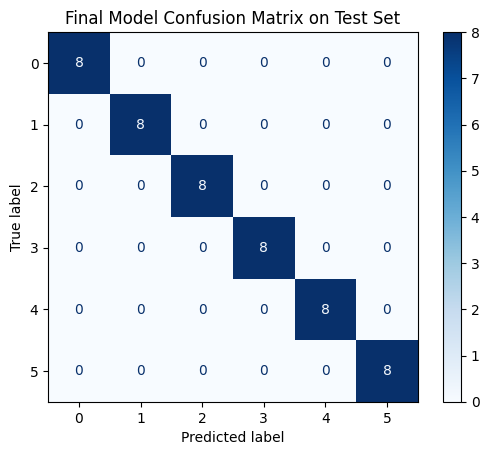

In [30]:
cm_final = confusion_matrix(y_test, y_test_pred_final, labels=final_best_model.classes_)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=final_best_model.classes_)
disp_final.plot(cmap=plt.cm.Blues)
plt.title("Final Model Confusion Matrix on Test Set")
plt.show()

### Learning Curve

In [31]:
import warnings
warnings.filterwarnings('ignore')

train_sizes, train_scores, test_scores = learning_curve(
    final_best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='f1_weighted',
    shuffle=True,
    random_state=42
)

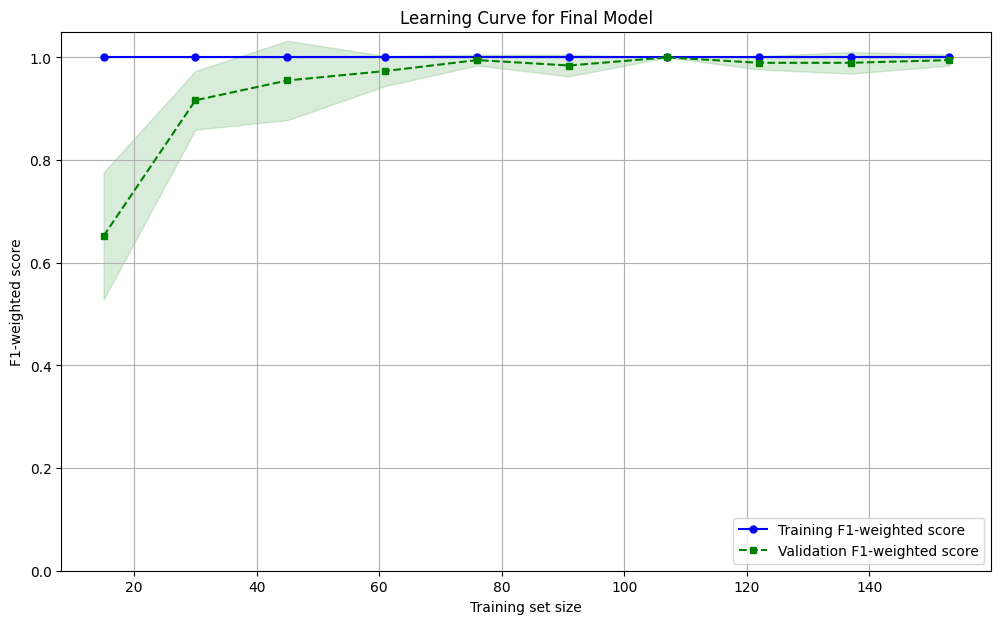

In [32]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training F1-weighted score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation F1-weighted score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Training set size')
plt.ylabel('F1-weighted score')
plt.title('Learning Curve for Final Model')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.05])
plt.show()